In [67]:
#import packages
import pandas as pd
import numpy as np
import re
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from keras.layers import Dense


import os

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\siree\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
#set working directory
os.chdir('C:/Users/siree/OneDrive/Desktop/WGU/D213/D213_Files')

In [15]:
#getting working directory
cwd = os.getcwd()
print(cwd)

C:\Users\siree\OneDrive\Desktop\WGU\D213\D213_Files


In [ ]:
###### B1: DATA EXPLORATION #######

In [16]:
# Load the dataset
data = pd.read_csv('amazon_cells_labelled.txt', delimiter='\t', header=None, names=['Review', 'Sentiment'])

In [17]:
# Display the first few rows
print(data.head())

                                              Review  Sentiment
0  So there is no way for me to plug it in here i...          0
1                        Good case, Excellent value.          1
2                             Great for the jawbone.          1
3  Tied to charger for conversations lasting more...          0
4                                  The mic is great.          1


In [18]:
#Function to find unusual characters
def find_unusual_characters(text):
    return re.findall(r'[^\x00-\x7F]+', text)

In [19]:
#Apply the function to the dataset
data['Unusual_Characters'] = data['Review'].apply(find_unusual_characters)

In [20]:
# Display reviews with unusual characters
unusual_characters_df = data[data['Unusual_Characters'].apply(lambda x: len(x) > 0)]
print(unusual_characters_df)

Empty DataFrame
Columns: [Review, Sentiment, Unusual_Characters]
Index: []


In [21]:
#Tokenize the reviews
data['Tokens'] = data['Review'].apply(word_tokenize)

In [22]:
#Count the unique words
vocabulary = Counter([word for tokens in data['Tokens'] for word in tokens])
vocabulary_size = len(vocabulary)
print(f'Vocabulary Size: {vocabulary_size}')

Vocabulary Size: 2235


In [23]:
#Proposed word embedding length
embedding_length = 100
print(f'Proposed Word Embedding Length: {embedding_length}')

Proposed Word Embedding Length: 100


In [24]:
#Calculate the length of each review
data['Review_Length'] = data['Tokens'].apply(len)

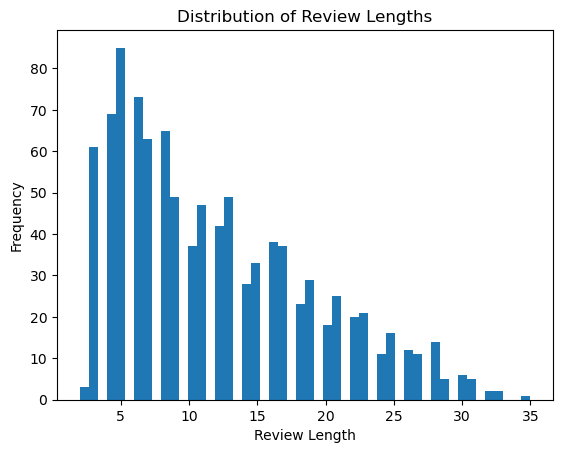

In [25]:
# Plot the distribution of review lengths
plt.hist(data['Review_Length'], bins=50)
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()

In [26]:
#Statistical summary
review_length_stats = data['Review_Length'].describe()
print(review_length_stats)

count    1000.000000
mean       11.965000
std         7.198166
min         2.000000
25%         6.000000
50%        10.000000
75%        17.000000
max        35.000000
Name: Review_Length, dtype: float64


In [27]:
#Calculate the 95th percentile
max_sequence_length = int(data['Review_Length'].quantile(0.95))
print(f'Chosen Maximum Sequence Length: {max_sequence_length}')

Chosen Maximum Sequence Length: 26


In [ ]:
#### B2: TOKENIZATION #######

In [28]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

In [29]:
def tokenize_and_normalize(text):
    normalized_text = normalize_text(text)
    tokens = word_tokenize(normalized_text)
    return tokens

In [30]:
#Example usage with a sample review
sample_review = "Good case, Excellent value!"
tokens = tokenize_and_normalize(sample_review)
print(tokens)

['good', 'case', 'excellent', 'value']


In [ ]:
##### B3: PADDING Process ######

In [31]:
#Tokenize and normalize
data['Tokens'] = data['Review'].apply(lambda x: word_tokenize(normalize_text(x)))

In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Tokens'])
sequences = tokenizer.texts_to_sequences(data['Tokens'])

In [34]:
#Define the maximum sequence length
max_sequence_length = 26

In [35]:
#Apply post padding
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

print(padded_sequences)

[[ 33 116   5 ...   0   0   0]
 [ 21  48  53 ...   0   0   0]
 [ 16  12   1 ...   0   0   0]
 ...
 [ 89  61  11 ...   0   0   0]
 [  1  73 134 ...   0   0   0]
 [ 23  64  11 ...   0   0   0]]


In [42]:
#Display the first padded sequence for visualization
print(padded_sequences[0])

[ 33 116   5  58 210  12  50   8 153   4  19 329  19   1 538 539   2 236
 185   6 790   0   0   0   0   0]


In [43]:
#Prepare the labels
labels = data['Sentiment'].values

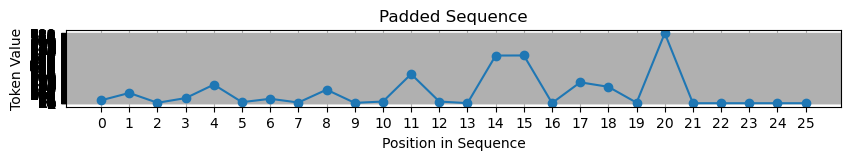

In [37]:
#Visualize a single padded sequence
sequence_index = 0  # Index of the sequence to visualize
padded_sequence = padded_sequences[sequence_index]

plt.figure(figsize=(10, 1))
plt.title("Padded Sequence")
plt.xlabel("Position in Sequence")
plt.ylabel("Token Value")
plt.xticks(np.arange(0, max_sequence_length, step=1))
plt.yticks(np.arange(0, np.max(padded_sequence) + 1, step=1))
plt.grid(True)
plt.plot(np.arange(max_sequence_length), padded_sequence, marker='o')
plt.show()

In [ ]:
##### B4: CATEGORIES OF SENTIMENT #######

In [56]:
#Define the model
vocab_size = len(tokenizer.word_index) + 1

In [57]:
model = Sequential()
model.add(Embedding(input_dim=2235, output_dim=100))
model.add(LSTM(units=128))
model.add(Dense(1, activation='softmax'))

In [58]:
#Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [59]:
#Summary of the model
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
### B5: STEPS TO PREPARE THE DATA ###############

In [50]:
#Split into training and remaining data
train_data, temp_data, train_labels, temp_labels = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)

In [51]:
#Split remaining data into validation and test sets
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42)

In [52]:
#Print sizes
print(f'Training set size: {len(train_data)}')
print(f'Validation set size: {len(val_data)}')
print(f'Test set size: {len(test_data)}')

Training set size: 700
Validation set size: 150
Test set size: 150


In [ ]:
###### B6: PREPARED DATA SET ######

In [54]:
#Create a DataFrame from the padded sequences and labels
prepared_data = pd.DataFrame(padded_sequences)
prepared_data['Sentiment'] = labels

In [55]:
#Save the DataFrame to a CSV file
prepared_data.to_csv('C:/Users/siree/OneDrive/Desktop/WGU/D213/TASK_2/SIREEN_SHABAN_D213_TASK2_prepared_data.csv', index=False)

In [ ]:
#### C1: MODEL SUMMARY #####

In [105]:
# Define the model parameters
vocab_size = 2236
embedding_dim = 100
max_length = 26

In [103]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Use 1 unit for binary classification
])

In [104]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [107]:
# To ensure the model is built, pass a dummy input through the model
dummy_input = tf.random.uniform((1, max_length))
model(dummy_input)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4904292]], dtype=float32)>

In [108]:
# Summary of the model
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (1, 26, 100)           │       190,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (1, 100)               │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (1, 100)               │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (1, 50)                │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (1, 1)                 │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,801 (803.91 KB)

 Trainable params: 205,801 (803.91 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
# Train the model
history = model.fit(
    train_data, train_labels,
    epochs=20,  # Set the number of epochs
    validation_data=(val_data, val_labels),
    callbacks=[early_stopping_callback]  # Include the early stopping callback
)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4853 - loss: 0.6935 - val_accuracy: 0.6067 - val_loss: 0.6908
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5714 - loss: 0.6881 - val_accuracy: 0.6400 - val_loss: 0.6819
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7609 - loss: 0.6684 - val_accuracy: 0.6267 - val_loss: 0.6553


In [110]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f'Test accuracy: {test_accuracy}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5238 - loss: 0.6917 
Test accuracy: 0.5400000214576721


In [ ]:
#### D1: STOPPING CRITERIA ######

In [111]:
# Define early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored quantity
)

In [112]:
# Train the model
history = model.fit(
    train_data, train_labels,
    epochs=20,  # Set the number of epochs
    validation_data=(val_data, val_labels),
    callbacks=[early_stopping_callback]  # Include the early stopping callback
)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7057 - loss: 0.6865 - val_accuracy: 0.6400 - val_loss: 0.6787
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7453 - loss: 0.6598 - val_accuracy: 0.7933 - val_loss: 0.6321
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7989 - loss: 0.5738 - val_accuracy: 0.7200 - val_loss: 0.5335
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8294 - loss: 0.4053 - val_accuracy: 0.8267 - val_loss: 0.4302
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9579 - loss: 0.2108 - val_accuracy: 0.8400 - val_loss: 0.4155
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9817 - loss: 0.1112 - val_accuracy: 0.7933 - val_loss: 0.4497
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9726 - loss: 0.0903 - val_accuracy: 0.8200 - val_loss: 0.4664
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9836 - loss: 0.0635 - val_accuracy: 0.8400 - val_loss:

In [113]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f'Test accuracy: {test_accuracy}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7788 - loss: 0.4465 
Test accuracy: 0.7933333516120911


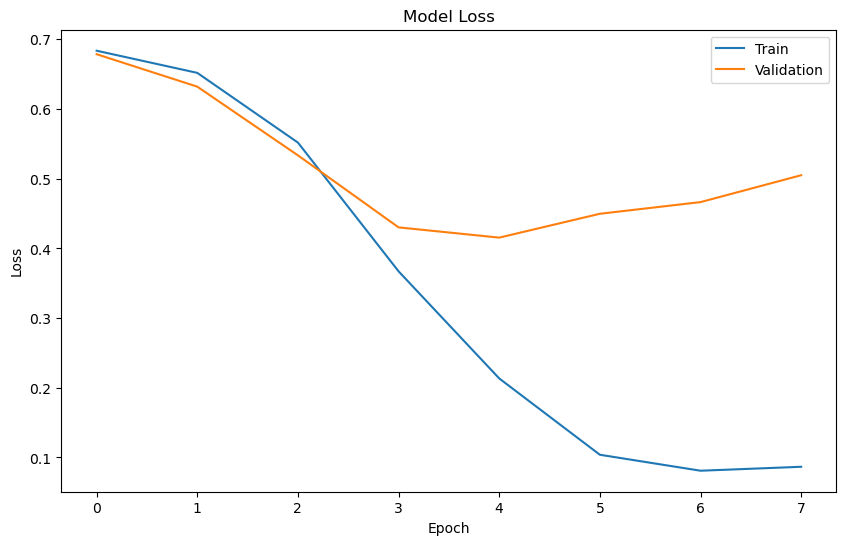

In [114]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [115]:
# Print the final epoch's information
final_epoch = len(history.history['loss']) - 1
print(f'Final training epoch: {final_epoch + 1}')
print(f'Final training loss: {history.history["loss"][final_epoch]}')
print(f'Final validation loss: {history.history["val_loss"][final_epoch]}')

Final training epoch: 8
Final training loss: 0.08658549189567566
Final validation loss: 0.5050196051597595


In [116]:
##### D3: TRAINING PROCESS #####

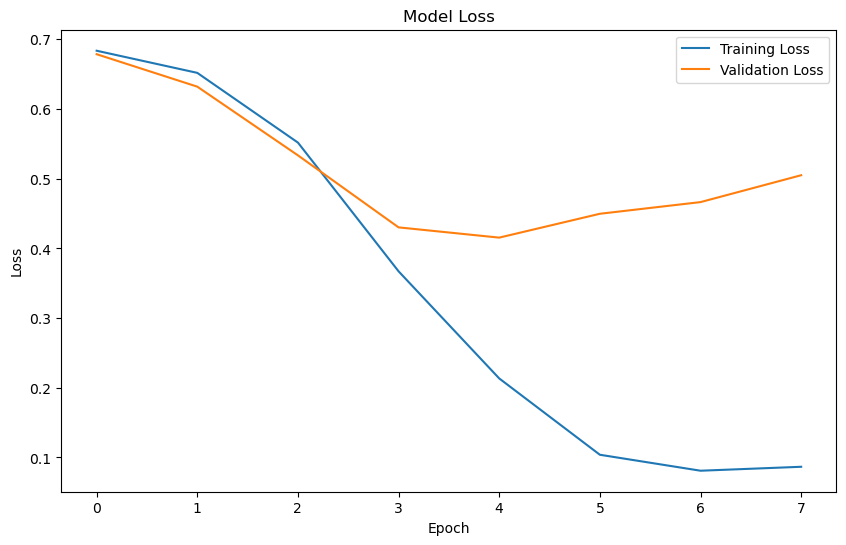

In [117]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

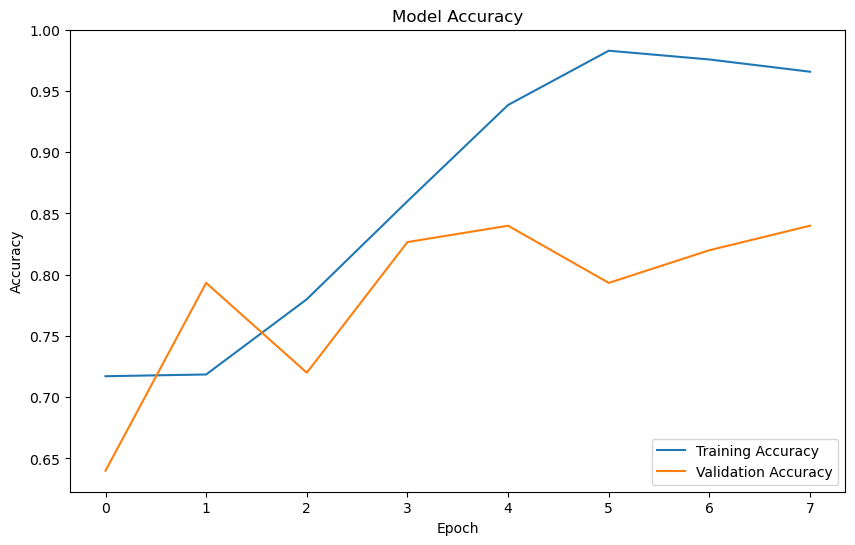

In [118]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
##### D4: PREDICTIVE ACCURACY ############

In [119]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f'Test accuracy: {test_accuracy}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7788 - loss: 0.4465 
Test accuracy: 0.7933333516120911
